In [70]:
# ===============================================
# Clean → Encode → Classify (KNN) — Simplified
# ===============================================
# Dataset: Kaggle "Mushroom Classification"
# Expected file: ./mushrooms.csv

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.impute import SimpleImputer  # used ONCE as an example
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [71]:
# -----------------------------
# 0) Load data
# -----------------------------
csv_path = "./mushrooms.csv"   # TODO: place the file or change path: DONE
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"Could not find {csv_path} — download from Kaggle and try again.")

df = pd.read_csv(csv_path)
print("Initial shape:", df.shape)
# TODO: Get the top 5 rows (1 line of code): DONE
print(df.head())

Initial shape: (8124, 23)
  class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
0            c         n          k  ...                        s   
1            c         b          k  ...                        s   
2            c         b          n  ...                        s   
3            c         n          n  ...                        s   
4            w         b          k  ...                        s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w                      w       

In [72]:
# -----------------------------
# 1) Basic cleaning (duplicates, empty rows)
# -----------------------------
before = df.shape[0]

# TODO: Remove duplicates (1 line of code): DONE
df = df.drop_duplicates()
print("Removed duplicates:", before - df.shape[0])

before = df.shape[0]
# TODO: Drop fully empty rows (1 line of code): DONE
df = df.dropna(how='all')

print("Dropped fully empty rows:", before - df.shape[0])

print("\nMissing values per column (top 10):")
# TODO: Display the missing values per column (1 line of code): DONE
df.isnull().sum()



Removed duplicates: 0
Dropped fully empty rows: 0

Missing values per column (top 10):


,0
class,0
cap-shape,0
cap-surface,0
cap-color,0
bruises,0
odor,0
gill-attachment,0
gill-spacing,0
gill-size,0
gill-color,0


In [73]:
# -----------------------------
# 2) Target & split
# -----------------------------
TARGET_COL = "class"  # TODO: change if your label column differs: DONE
if TARGET_COL not in df.columns:
    raise ValueError("Update TARGET_COL to match your dataset's label column.")

# TODO: Drop the target column from the "X" (1 line of code): DONE
X = df.drop(columns=[TARGET_COL])
# TODO: Set up the target column (1 line of code): DONE
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)
print("\nTrain/Test shapes:", X_train.shape, X_test.shape)

# Detect types BEFORE imputation/encoding
orig_numeric_cols = X.select_dtypes(include=['number']).columns.tolist() # TODO: Extract the numeric columns from the training data set and store it as a list: DONE
orig_categorical_cols = X.select_dtypes(exclude=['number']).columns.tolist() # TODO: Extract the categorical columns from the training data set and store it as a list: DONE
print("Original numeric cols:", orig_numeric_cols if orig_numeric_cols else "None")
print("Original categorical cols (sample):", orig_categorical_cols[:10])


Train/Test shapes: (6499, 22) (1625, 22)
Original numeric cols: None
Original categorical cols (sample): ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape']


In [74]:
# --------------------------------------------
# 3) IMPUTATION (MANUAL) + one sklearn example
# --------------------------------------------
# Manual imputation rules:
#  - Numeric: fill with TRAIN median
#  - Categorical: fill with TRAIN mode
# NOTE: We compute imputation values on TRAIN only, then apply to both TRAIN & TEST.

X_train_imp = X_train.copy()
X_test_imp  = X_test.copy()

# a) Numeric → manual median
# TODO: For each of the columns, fill the empty values with the median of the column (4 lines of code): DONE
# TODO: Do this for the training and test data separately.: DONE

numeric_cols = X_train.select_dtypes(include=['number']).columns
medians = X_train[numeric_cols].median()
X_train[numeric_cols] = X_train[numeric_cols].fillna(medians)
X_test[numeric_cols] = X_test[numeric_cols].fillna(medians)


# b) Categorical → manual mode
# TODO: For each of the columns, fill the empty values with the median of the column (4-5 lines of code): DONE
# TODO: Do this for the training and test data separately.: DONE
categorical_cols = X_train.select_dtypes(exclude=['number']).columns
modes = X_train[categorical_cols].mode().iloc[0]
X_train[categorical_cols] = X_train[categorical_cols].fillna(modes)
X_test[categorical_cols] = X_test[categorical_cols].fillna(modes)

# c) One EXAMPLE using sklearn SimpleImputer on a SINGLE column (categorical)
# Choose a categorical column present in your dataset:
IMPUTE_EXAMPLE_COL = "odor"  # TODO: change if needed: DONE
if IMPUTE_EXAMPLE_COL in X_train_imp.columns:
    cat_imp = SimpleImputer(strategy="most_frequent")
    X_train_imp[IMPUTE_EXAMPLE_COL] = cat_imp.fit_transform(X_train_imp[[IMPUTE_EXAMPLE_COL]]).ravel() #modified by me
    X_test_imp[IMPUTE_EXAMPLE_COL]  = cat_imp.transform(X_test_imp[[IMPUTE_EXAMPLE_COL]]).ravel() #modified by me
    print(f"\nUsed sklearn SimpleImputer on column: {IMPUTE_EXAMPLE_COL}")
else:
    print(f"\n[Note] Example imputer column '{IMPUTE_EXAMPLE_COL}' not found. Skipping sklearn example.")



Used sklearn SimpleImputer on column: odor


In [75]:
# --------------------------------------------
# 4) ENCODING
#    - EXPLICIT One-Hot Encoding on ONE chosen column
#    - Then get_dummies for the remaining categoricals
# --------------------------------------------
# Choose the column for explicit OHE:
EXPLICIT_OHE_COL = "odor"  # TODO: change if needed: DONE

X_train_enc = X_train_imp.copy()
X_test_enc  = X_test_imp.copy()

if EXPLICIT_OHE_COL in X_train_enc.columns:
    # TODO: EXPLICIT OHE on this ONE column — fit on TRAIN only and TEST only separately (2 lines of code): DONE
    train_ohe = pd.get_dummies(X_train_enc[EXPLICIT_OHE_COL], prefix=EXPLICIT_OHE_COL)
    test_ohe  = pd.get_dummies(X_test_enc[EXPLICIT_OHE_COL], prefix=EXPLICIT_OHE_COL)

    # Align test columns to train (avoid unseen-category issues)

    test_ohe = test_ohe.reindex(columns=train_ohe.columns, fill_value=0)

    # Drop original column and concat OHE columns
    X_train_enc = pd.concat([X_train_enc.drop(columns=[EXPLICIT_OHE_COL]), train_ohe], axis=1)
    X_test_enc  = pd.concat([X_test_enc.drop(columns=[EXPLICIT_OHE_COL]),  test_ohe], axis=1)

    print(f"\nExplicit OHE applied to column: {EXPLICIT_OHE_COL}")
else:
    print(f"\n[Note] Explicit OHE column '{EXPLICIT_OHE_COL}' not found. Skipping explicit OHE step.")

# TODO: Identify remaining categorical columns (post explicit OHE drop) in the TRAINING data set only (1 line of code): DONE
remaining_categorical_cols = X_train.select_dtypes(exclude=['number']).columns.tolist()
print(remaining_categorical_cols)

# TODO: Apply get_dummies to the remaining categoricals (fit on TRAIN, align TEST) (1 lines of code): DONE
X_train_enc, X_test_enc = pd.get_dummies(X_train, columns=remaining_categorical_cols,  drop_first=False).align(pd.get_dummies(X_test,columns=remaining_categorical_cols,  drop_first=False), join='left', axis=1, fill_value=0)

# Align test columns to train columns (VERY IMPORTANT)
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)


print("Encoded train shape:", X_train_enc.shape)
print("Encoded test shape:", X_test_enc.shape)


Explicit OHE applied to column: odor
['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']
Encoded train shape: (6499, 117)
Encoded test shape: (1625, 117)


In [76]:
# --------------------------------------------
# 5) NORMALIZE numeric columns (if any)
#    (Scale ONLY the original numeric columns; don't scale one-hot columns)
# --------------------------------------------
numeric_cols_to_scale = [c for c in orig_numeric_cols if c in X_train_enc.columns]

if numeric_cols_to_scale:
  # TODO: Use the Standard Scaler to scale the numeric values (1 line of code): DONE
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    # TODO: Fit the scaler and scale the train and test data separately. (3 lines of code)
    X_train_enc[numeric_cols_to_scale] = scaler.fit_transform(X_train_enc[numeric_cols_to_scale])
    X_test_enc[numeric_cols_to_scale]  = scaler.transform(X_test_enc[numeric_cols_to_scale])
    # TODO: Print the names of the columns scaled if any (4 lines of code at max)
    print("Scaled columns:", numeric_cols_to_scale)
else:
    print("No numeric columns to scale – skipping scaling step.")

No numeric columns to scale – skipping scaling step.


In [77]:
# --------------------------------------------
# 6) KNN + Grid Search
# --------------------------------------------
neighbor_values = [3, 5, 7, 9, 11, 15, 21]
weight_types = ['uniform', 'distance']

# TODO: Use the KNN Classifier to classify the data
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_enc, y_train)
y_pred = knn.predict(X_test_enc)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:", classification_report(y_test, y_pred))
print("Confusion Matrix:", confusion_matrix(y_test, y_pred))
# TODO: Test for number of neighbors in the set [3, 5, 7, 9, 11, 15, 21]
# TODO: Try both the types of weights
# does both
for w in weight_types:
    for k in neighbor_values:
        knn = KNeighborsClassifier(n_neighbors=k, weights=w)
        knn.fit(X_train_enc, y_train)
        y_pred = knn.predict(X_test_enc)
        acc = accuracy_score(y_test, y_pred)
        print(f"weights = {w:<8} | k = {k:<2} → Accuracy: {acc:.4f}")
# TODO: Also try Manhattan and Euclidean distances.
# Find and print the best_estimator_ and print the best parameters
# Roughly 7 - 9 lines of code including printing the
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_neighbors': neighbor_values,
    'weights': weight_types,
    'metric': ['minkowski'],
    'p': [1, 2]
}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_enc, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Estimator:", grid.best_estimator_)

Accuracy: 1.0
Classification Report:               precision    recall  f1-score   support

           e       1.00      1.00      1.00       842
           p       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

Confusion Matrix: [[842   0]
 [  0 783]]
weights = uniform  | k = 3  → Accuracy: 1.0000
weights = uniform  | k = 5  → Accuracy: 1.0000
weights = uniform  | k = 7  → Accuracy: 1.0000
weights = uniform  | k = 9  → Accuracy: 1.0000
weights = uniform  | k = 11 → Accuracy: 0.9988
weights = uniform  | k = 15 → Accuracy: 0.9982
weights = uniform  | k = 21 → Accuracy: 0.9982
weights = distance | k = 3  → Accuracy: 1.0000
weights = distance | k = 5  → Accuracy: 1.0000
weights = distance | k = 7  → Accuracy: 1.0000
weights = distance | k = 9  → Accuracy: 1.0000
weights = distance | k = 11 → Accuracy: 1.0000
weights = distance | k = 15 → A


Test accuracy: 1.0000

Classification report:
               precision    recall  f1-score   support

           e       1.00      1.00      1.00       842
           p       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



<Figure size 640x480 with 0 Axes>

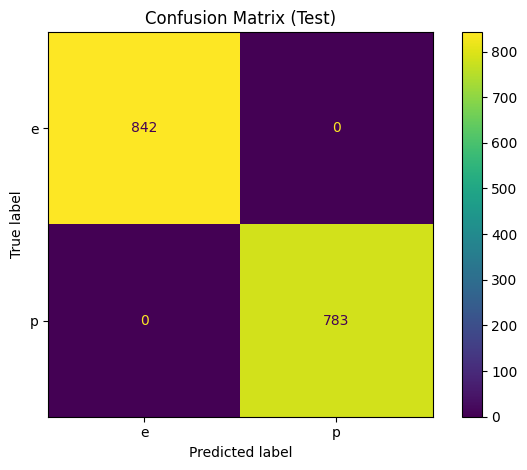

In [78]:
# --------------------------------------------
# 7) Evaluate on held-out TEST
# --------------------------------------------
# TODO: Use KNN to make predictions on the test dataset (1 line of code)
y_pred = grid.best_estimator_.predict(X_test_enc)

test_acc = accuracy_score(y_test, y_pred)
print("\nTest accuracy: {:.4f}".format(test_acc))
print("\nClassification report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
plt.figure()
disp.plot(values_format="d")
plt.title("Confusion Matrix (Test)")
plt.tight_layout()
plt.show()

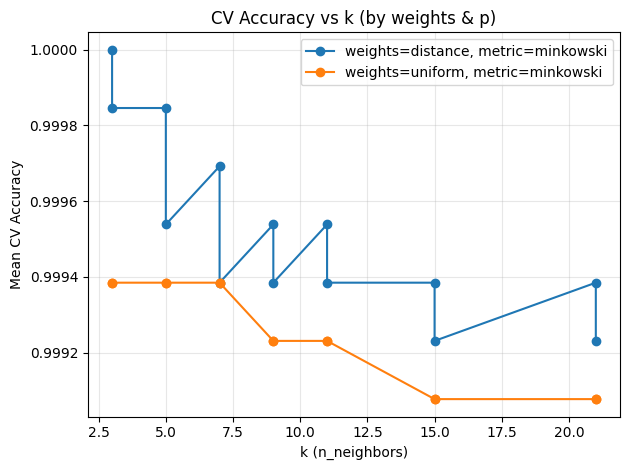

In [79]:
# --------------------------------------------
# 8) Validation curve (CV accuracy vs k)
# --------------------------------------------
cvres = pd.DataFrame(grid.cv_results_)
plotdf = cvres[["param_n_neighbors", "param_weights", "param_metric", "mean_test_score"]].rename(
    columns={"param_n_neighbors":"k", "param_weights":"weights", "param_metric":"metric"}
)
plt.figure()
for (w, metric), sub in plotdf.groupby(["weights", "metric"]):
    sub = sub.sort_values("k")
    plt.plot(sub["k"], sub["mean_test_score"], marker="o", label=f"weights={w}, metric={metric}")

plt.xlabel("k (n_neighbors)")
plt.ylabel("Mean CV Accuracy")
plt.title("CV Accuracy vs k (by weights & p)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

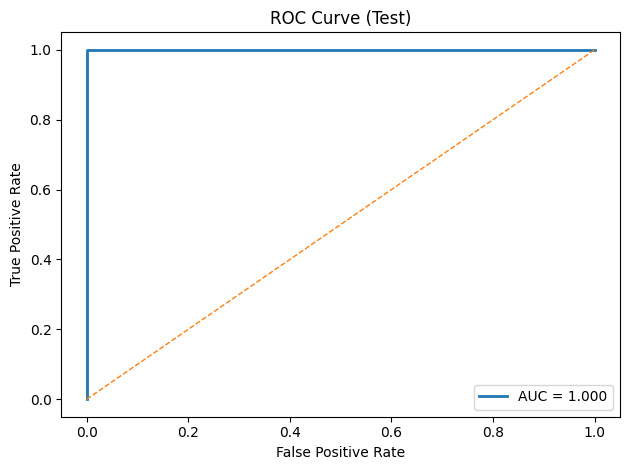

In [80]:
# --------------------------------------------
# 9) ROC curve (binary; micro-average if multiclass)
# --------------------------------------------
best_knn = grid.best_estimator_
if hasattr(best_knn, "predict_proba"):
    classes_ = np.unique(y_train)
    y_test_enc_int = pd.Categorical(y_test, categories=classes_).codes
    proba = best_knn.predict_proba(X_test_enc)

    if len(classes_) == 2:
        fpr, tpr, _ = roc_curve(y_test_enc_int, proba[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
        plt.plot([0, 1], [0, 1], lw=1, linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (Test)")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()
    else:
        y_bin = label_binarize(y_test_enc_int, classes=range(len(classes_)))
        fpr, tpr, _ = roc_curve(y_bin.ravel(), proba.ravel())
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, lw=2, label=f"Micro-average AUC = {roc_auc:.3f}")
        plt.plot([0, 1], [0, 1], lw=1, linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (Micro-average)")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()


In [81]:
# --------------------------------------------
# 10) Print summary of features
# Sample Output: Final feature count: 25
# Best KNN: KNeighborsClassifier(n_neighbors=7, p=2, weights='distance')
# --------------------------------------------
# TODO: Print the final stats (2 lines of code)
print("Final number of features:", X_train_enc.shape[1])
print("Best KNN model:", best_knn)

Final number of features: 117
Best KNN model: KNeighborsClassifier(n_neighbors=3, p=1, weights='distance')
